In [1]:
import ddr_tools as ddr #custom module
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact #interactive plots
import os
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter

In [2]:
# data 
L = 0.5 # semi-side
rho = 0.25
sigma_min = 0.1
sigma_plus = 1
phi_datum = lambda x,y: 0.5
phi_gamma = 0.5
g_min  = -1
g_plus =  1
    
A_min  = sigma_plus/(sigma_plus+sigma_min)*(g_plus-g_min-phi_gamma)/L
A_plus = sigma_min/sigma_plus*A_min
B_min  = g_min+A_min*L
B_plus = g_plus-A_plus*L

# ref sol: expressions in x,y 
ref_sol_min = lambda x,y: A_min*(x+L)+g_min
ref_sol_plus = lambda x,y: A_plus*(x-L)+g_plus

# wrapper ref sol that can be called by ref_sol(mesh,ino)
ref_sol = lambda mesh, dof, \
          ref_sol_min=ref_sol_min, ref_sol_plus=ref_sol_plus: \
          ddr.reference_1D_solution(mesh, dof, ref_sol_min, ref_sol_plus) 

eta = 1e6               

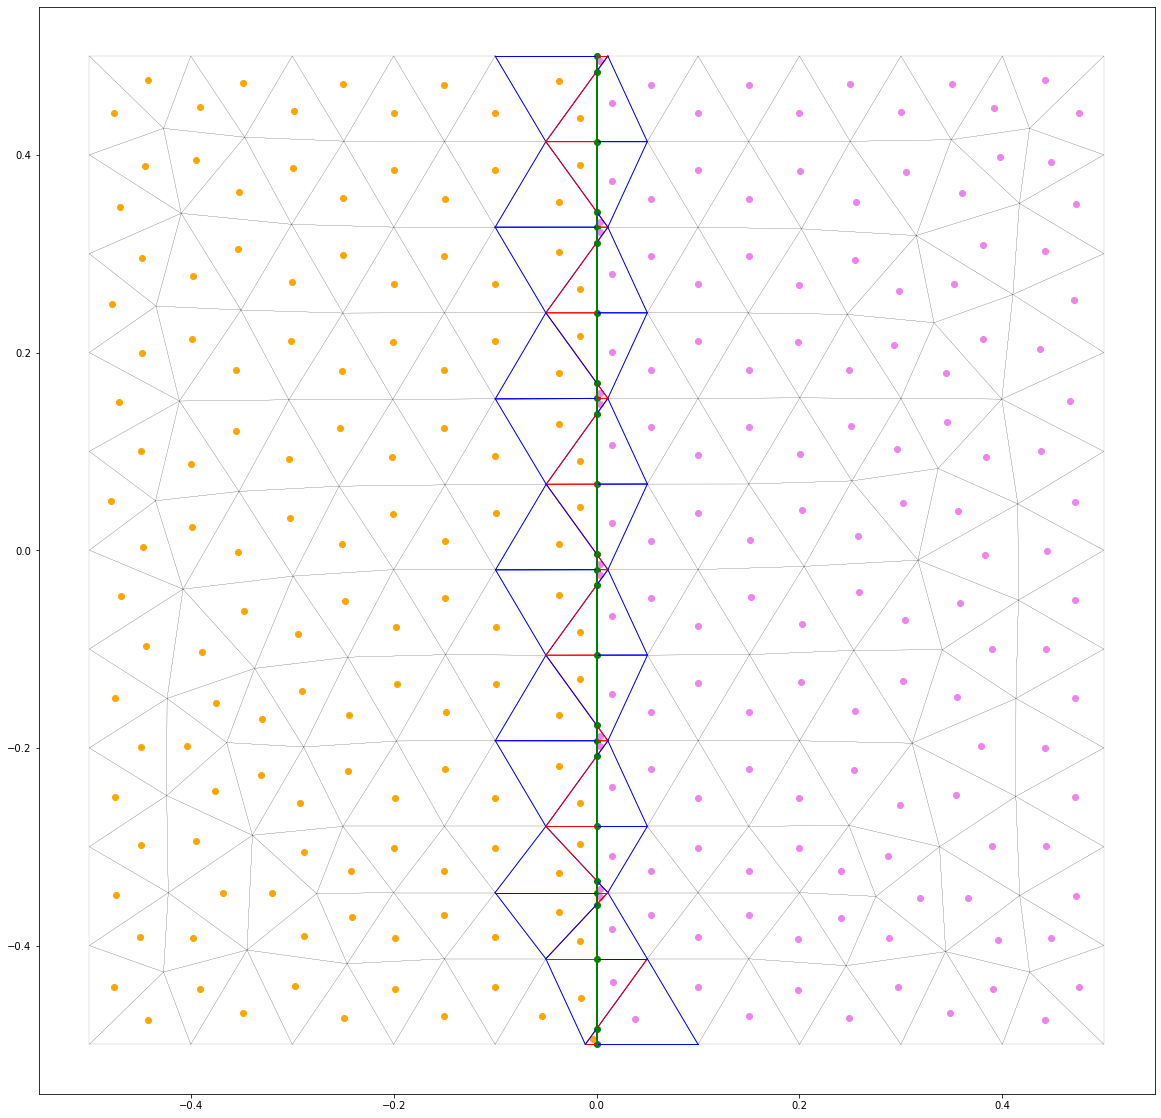

In [3]:
# load mesh
mesh_filename = "square_L1_N10.msh"
mesh = ddr.load_square_mesh(mesh_filename)
# move critical points near the interface
ddr.move_critical_points_1D(mesh)
# break mesh
ddr.break_mesh_1D(mesh)
ddr.visualize_mesh_1D(mesh)

In [6]:
meshname = "square_L1_N10"
[mesh, G, G_no_sigma, S, M_gamma, N_gamma, b_phi, A, b, u, err_L0, err_energy] = \
        ddr.solve_problem_1D(meshname+".msh", meshname+".vtk", \
                          ref_sol, sigma_min, sigma_plus, eta, phi_datum)

NameError: name 'phi_datum' is not defined

In [4]:
# CONVERGENCE STUDY: Solve problem for each mesh in the sequence and record error 
size_list = [5, 10, 20, 40]
mesh_filenames = ["square_L1_N"+str(size)+".msh" for size in size_list]
Meshes = []
G_matrices = []
G_no_sigma_matrices = []
S_matrices =[]
M_gamma_matrices = []
N_gamma_matrices = []
b_phi_matrices = []
solutions = []
errors_L0 = []
errors_energy = []
solution_filenames = ["square_L1_N"+str(size)+".vtk" for size in size_list]

for (i,N) in enumerate (size_list):
    [mesh, G, G_no_sigma, S, M_gamma, N_gamma, b_phi, A, b, u, err_L0, err_energy] = \
        ddr.solve_problem_1D(mesh_filenames[i], solution_filenames[i], \
                             ref_sol, sigma_min, sigma_plus, eta, phi_datum)
    Meshes.append(mesh)
    G_matrices.append(G)
    G_no_sigma_matrices.append(G_no_sigma)
    S_matrices.append(S)
    M_gamma_matrices.append(M_gamma)
    N_gamma_matrices.append(N_gamma)
    b_phi_matrices.append(b_phi)
    solutions.append(u)
    errors_L0.append(err_L0)
    errors_energy.append(err_energy)

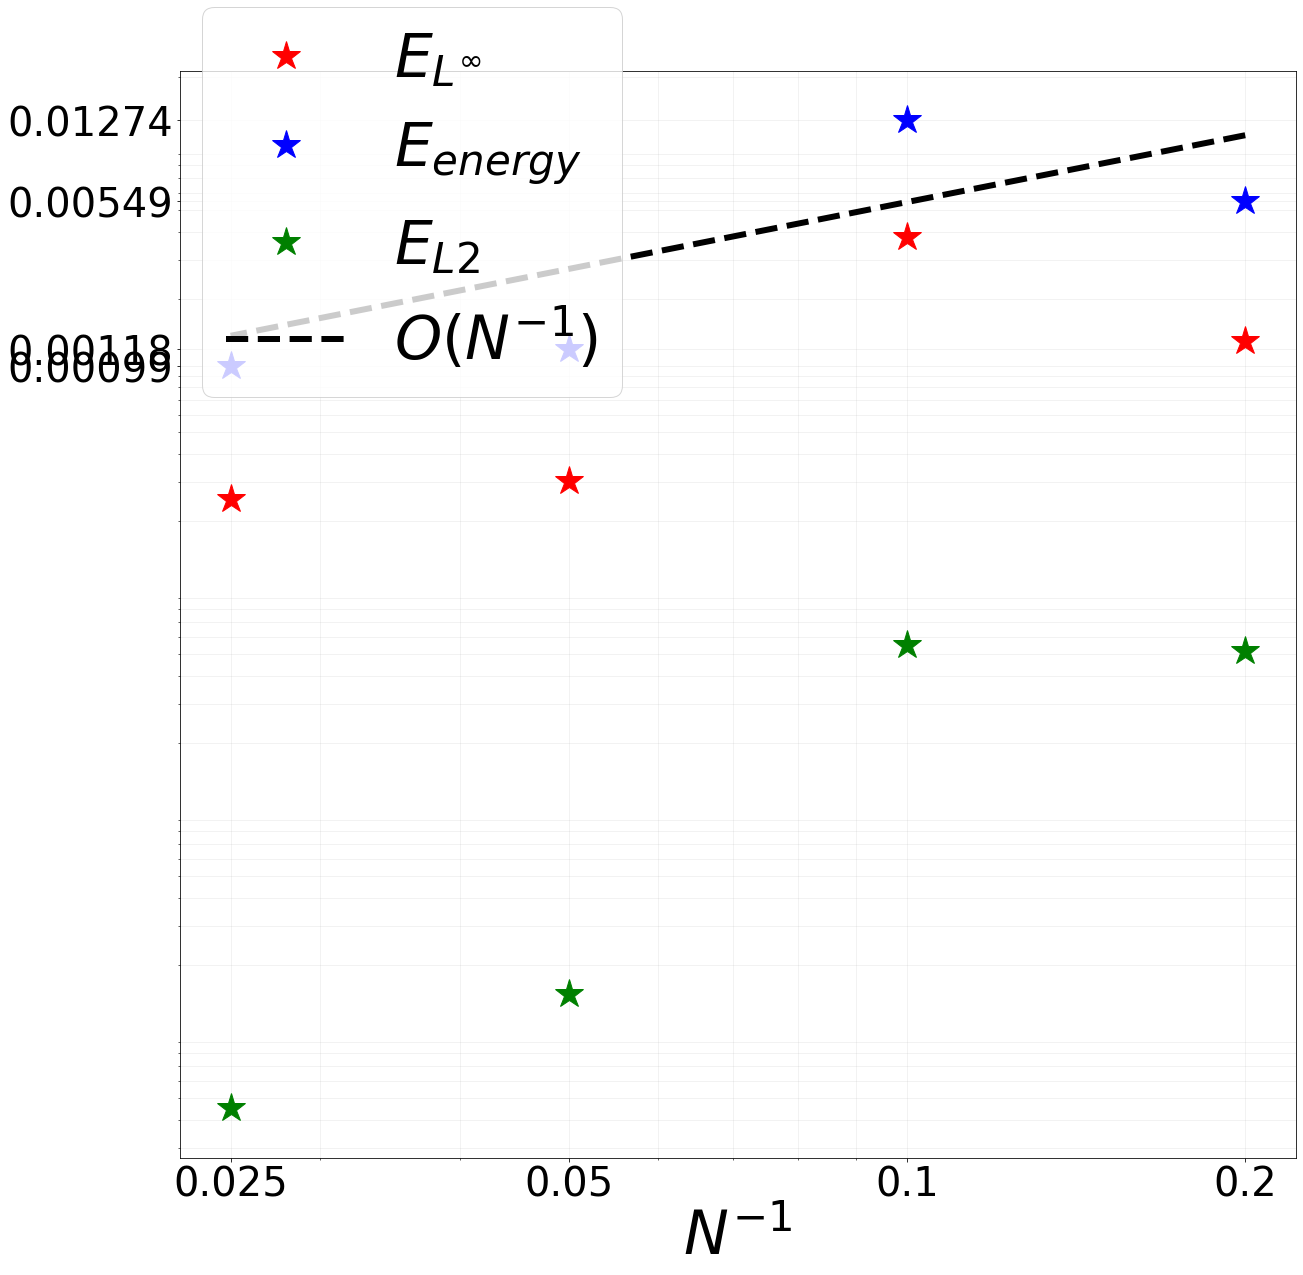

In [8]:
legend_size = 60
label_size = 40
fig_size = 20
line_width = 6
axis_name_size = 60
marker_size = 30

fig,ax = plt.subplots(figsize=(fig_size,fig_size))
h = [1/N for N in size_list]

solutions_ref = [np.array([ ref_sol(mesh,dof) for dof in range(mesh.Ndof)]) for mesh in Meshes]
errors_L2 = [np.linalg.norm(u-u_ref)/u.shape[0] for (u, u_ref) in zip(solutions, solutions_ref)]

ax.loglog(h,errors_L0, '*', label="$E_{L^\infty}$", markersize = marker_size, color="red")
ax.loglog(h,errors_energy, '*', label="$E_{energy}$", markersize = marker_size, color="blue")
ax.loglog(h,errors_L2, '*', label="$E_{L2}$", markersize = marker_size, color="green")
ax.loglog(h,h/np.mean(h)*np.mean(errors_energy),'--', label="$O(N^{-1})$", color="black", linewidth= line_width )


# Customize tick formatting
#plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(h))
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Set the ticks at each data point
plt.xticks(h,h)
plt.yticks(errors_energy)

#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.tick_params(axis='x', which='both', labelsize=label_size)
ax.tick_params(axis='y', which='both', labelsize=label_size)
ax.set_xticks(h)

#grid
ax.grid(alpha=0.2,which='both')

# legend and axis label
legend = ax.legend(prop={'size': legend_size},loc=(0.02,0.7) ) 
ax.set_xlabel('$N^{-1}$',fontsize=axis_name_size)
#ax.set_ylabel('$$',fontsize=axis_name_size) 
# tick setting

#plt.show()
plt.savefig('L0_convergence.png')
ax.grid('on')

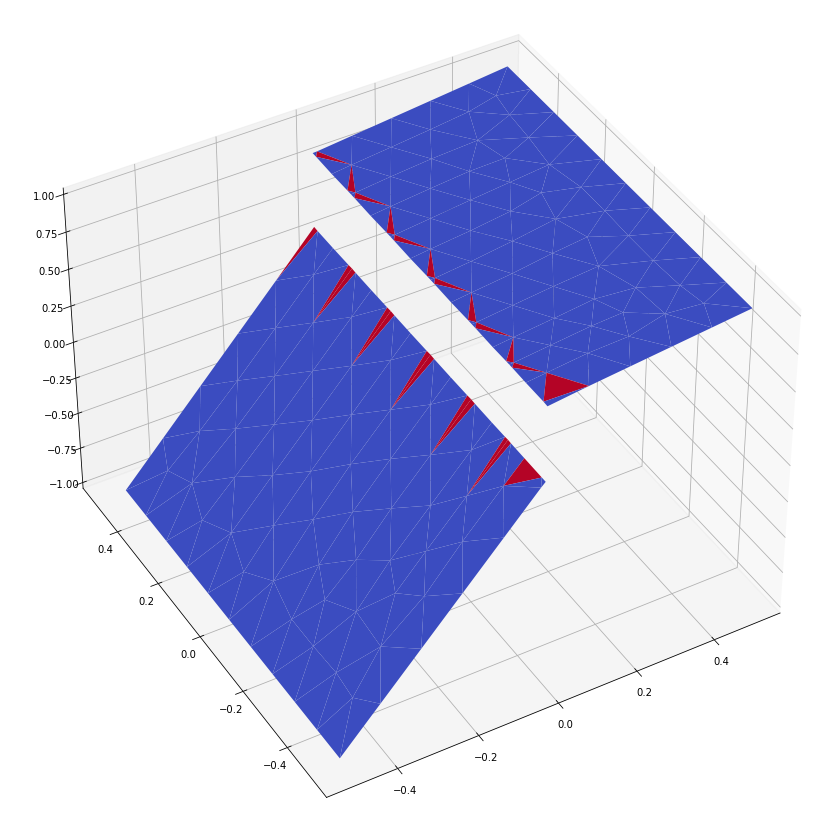

Error:  0.01274295194996074


In [9]:
n = 1
G_no_sigma = G_no_sigma_matrices[n]
N_gamma = N_gamma_matrices[n]
S = S_matrices[n]
ddr.plot_solution(Meshes[n], solutions[n], elevation=40, azimuth=-120)
print ("Error: ", ddr.calc_energy_error(Meshes[n],solutions[n],ref_sol, G_no_sigma, N_gamma, S))

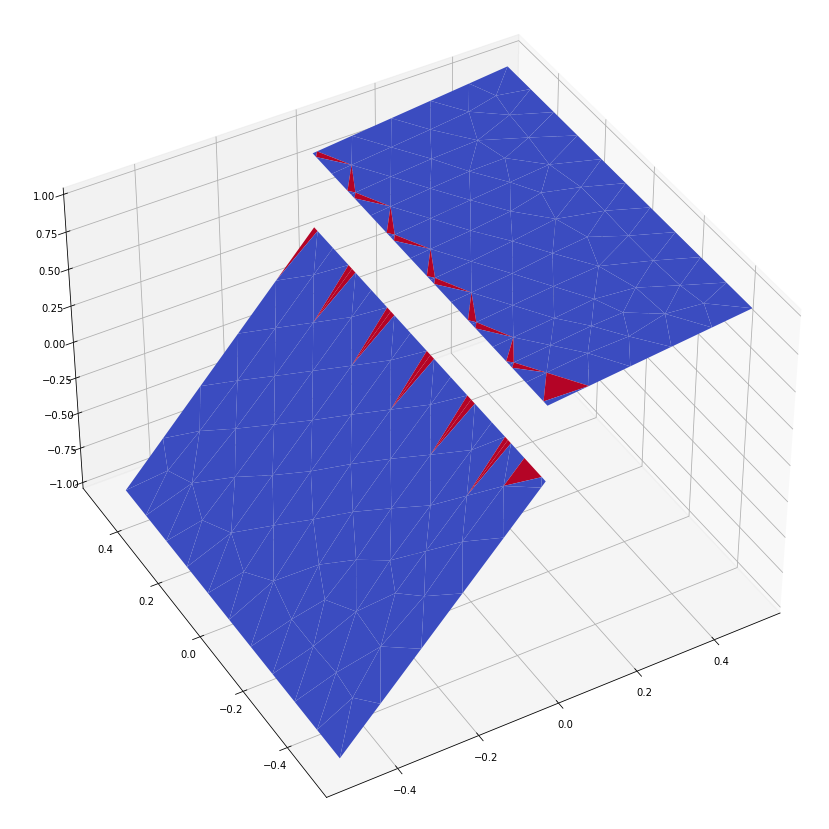

Error:  0.0


In [10]:
mesh = Meshes[n]
G_no_sigma = G_no_sigma_matrices[n]
N_gamma = N_gamma_matrices[n]
S = S_matrices[n]
u_ref = np.array([ ref_sol(mesh,dof) for dof in range(mesh.Ndof)])
ddr.plot_solution(mesh, u_ref, elevation=40, azimuth=-120)
print ("Error: ", ddr.calc_energy_error(mesh,u_ref,ref_sol, G_no_sigma, N_gamma, S))

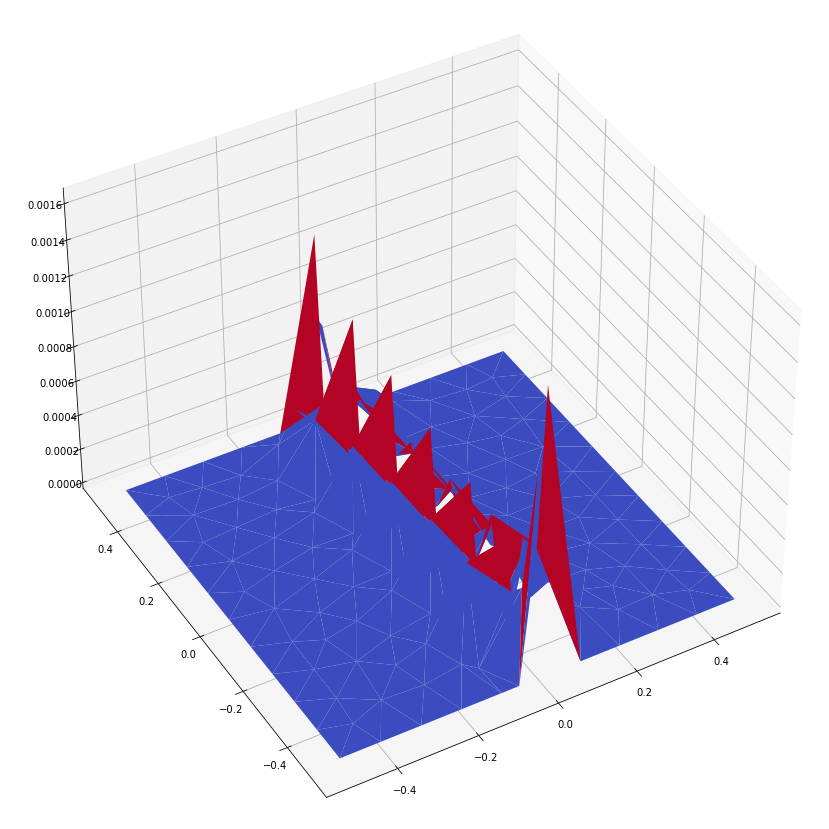

Error:  0.0


In [9]:
mesh = Meshes[n]
u = solutions[n]
u_ref = np.array([ ref_sol(mesh,dof) for dof in range(mesh.Ndof)])
ddr.plot_solution(mesh, np.abs(u_ref-u), elevation=40, azimuth=-120)
print ("Error: ", ddr.calc_L0_error(mesh,u_ref,ref_sol))

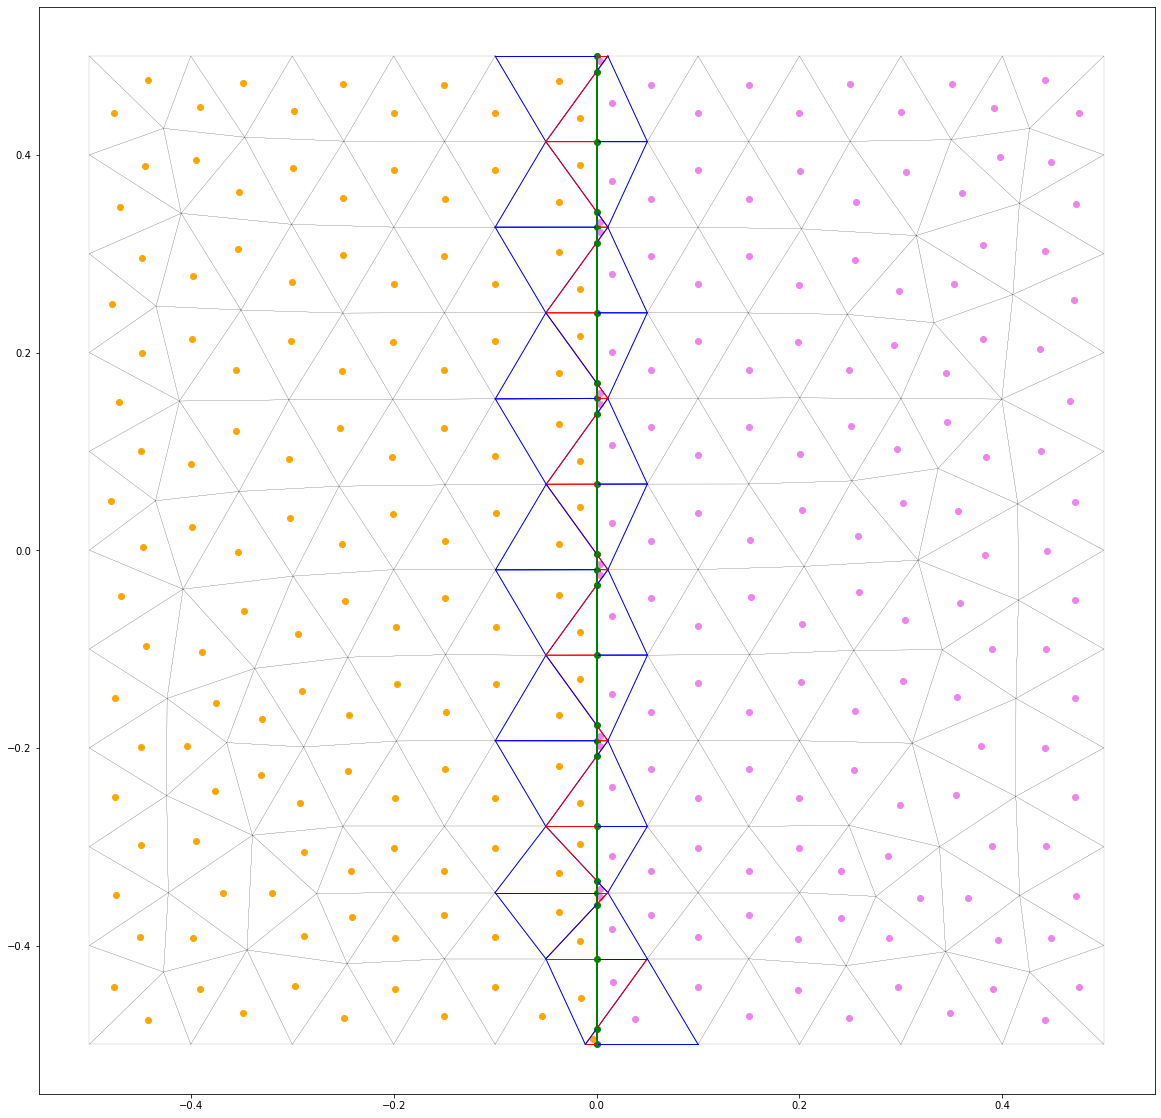

In [11]:
ddr.visualize_mesh_1D(Meshes[n])